### Оглавление
1. Загрузка библиотек
2. Импорт файлов
3. Предобработка текста
4. Модель №1: "Наивный" байесовский классификатор
5. Модель 2: SVM(метод опорных векторов) классификатор
6. Метрики качества PR-Curve, ROC-AUC curve.

### 1. Загрузка библиотек

In [0]:
import pandas as pd
import numpy as np
import nltk
import re
import string 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support as score, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC

### 2. Импорт файлов

In [0]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving test_1.csv to test_1.csv
Saving train.csv to train.csv
Saving train_2.csv to train_2.csv


In [0]:
def load_data(path):
    data = pd.read_csv(path)
    x = data['reviewText'].tolist()
    y = data['sentiment'].tolist()
    return x, y

In [0]:
train_x, train_y = load_data('train.csv')
test_x, test_y = load_data('test.csv')

In [5]:
print('training size:', len(train_x))
print('test size:', len(test_x))

training size: 25000
test size: 25000


### 3. Предобработка текста

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Наша задача:
1. убрать "стоп-слова" (местоимения, предлоги и проч.)
2. лемметизировать слова, то есть привести слово к его нормальной (словарной) форме
3. убрать лишинюю пунктуацию 

In [0]:
lemmatizer = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

In [0]:
def preprocessing(line: str) -> str:
    line = line.replace('<br />', '').translate(transtbl)
    
    tokens = [lemmatizer.lemmatize(t.lower(),'v')
              for t in nltk.word_tokenize(line)
              if t.lower() not in stopwords]
    
    return ' '.join(tokens)

In [9]:
test_str = "Me and my imaginary friend made some data-science, statistical researchs yeasterday!"
preprocessing(test_str)

'imaginary friend make data science statistical research yeasterday'

Успех сопутсвует нам:
1. Me and my-убраны
2. made стало make
3. -,! убраны

In [0]:
train_x = list(map(preprocessing, train_x))
test_x = list(map(preprocessing, test_x))

In [0]:
all_words = []
for line in train_x:
    words = line.split()
    for w in words:
        all_words.append(w)
        
vocabulary = nltk.FreqDist(all_words)

In [12]:
vocabulary.most_common(10)

[('film', 48170),
 ('movie', 43912),
 ('one', 26747),
 ('make', 23538),
 ('like', 22335),
 ('see', 20773),
 ('get', 18108),
 ('time', 16143),
 ('good', 15124),
 ('character', 14153)]

Замапили наши сеты и получили топ 10 по частоте упоминания слов

In [0]:

topwords = [fpair[0] for fpair in list(vocabulary.most_common(10000))]

Создаем словарик с 10000 самых частно встречаемых примеров слов

In [14]:
cnt_vec = CountVectorizer()
cnt_vec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [15]:
cnt_vec.fit(topwords)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

**TF**  — это частотность термина, которая измеряет, насколько часто термин встречается в документе, деленное на количество раз на общее количество слов в тексте.

**IDF** — это обратная частотность документов. Она измеряет непосредственно важность термина (в отличие от ТF, где все термины считаются как бы равными по важности друг другу). Он считается как логарифм от общего количества документов, делённого на количество документов, в которых встречается термин а.

Мы обходим каждый текст в корпусе текстов, считаем для него TF всех слов, находящихся в нем. Затем для каждого слова считаем IDF и умножаем его на уже посчитанный TF. Полученный словарь (dictionary) мы добавляем в список, чтобы сохранить такой же порядок текстов, какой был на входе. И возвращаем этот список словарей с посчитанными TF-IDF для каждого термина.

**TF-IDF термина а = (TF термина а) * (IDF термина а)**

In [16]:

from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [17]:
tf_vec = TfidfVectorizer()
tf_vec.fit(topwords)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [18]:
t_corpus = ['i hate nltk library', 'i love nltk library'] # Voc = ['i', 'hate', 'love', 'nltk', 'library']
t_cnt_vec = CountVectorizer()
t_cnt_vec.fit(' '.join(t_corpus).split())
t_cnt_vec.transform(t_corpus).toarray()

array([[1, 1, 0, 1],
       [0, 1, 1, 1]])

In [19]:
t_tfidf_vec = TfidfVectorizer()
t_tfidf_vec.fit(' '.join(t_corpus).split())
t_tfidf_vec.transform(t_corpus).toarray()

array([[0.64485945, 0.54044255, 0.        , 0.54044255],
       [0.        , 0.54044255, 0.64485945, 0.54044255]])

In [20]:
tf_vec = TfidfVectorizer(vocabulary=topwords)
train_features = tf_vec.fit_transform(train_x)
train_features.shape


(25000, 10000)

In [0]:
test_features = tf_vec.transform(test_x)

In [0]:
len(test_y)

25000

### 4. Модель №1: "Наивный" байесовский классификатор

Допустим С- наш отзывы (pos и neg). О- строка отзыва. Тогда по формуле Байеса вероятность получить класс в котором будет данная строка:

![alt text](https://habrastorage.org/getpro/habr/post_images/5f0/ba1/6fa/5f0ba16fae1e4613485d29e1fa62a4e4.png)


Знаменатель нас не интересует-он постоянный и мы его посчитали. Нет смысла работать со всей строкой. Намного эффективней выделить из нее определенные признаки (слова), что мы и сделали выше. Таким образом формула примет вид:

![alt text](https://habrastorage.org/getpro/habr/post_images/e92/4d2/63b/e924d263b59e77a4026a48dab0cad9ae.png)

![alt text](https://habrastorage.org/getpro/habr/post_images/f60/17a/e3b/f6017ae3be1985b9e9900920c05659d3.png)

Т.е. все что нужно сделать, это вычислить вероятности P( C )-вероятность нашего класса вот всех отзывах и P(O|C)-вероятность встретить наши слова-признаки в классе. Вычисление этих параметров и будет нашим обучением  классификатора.

Bernoulli NB + TF-IDF(Alpha = 0)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Test_accuracy 82.504
Train_accuracy 86.488
precision:[0.79527616 0.86147687], reccall:[0.87544 0.77464], accuracy:0.82504, fscore[0.83343488 0.815754  ]


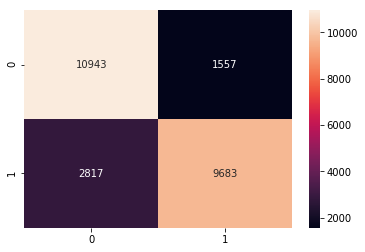

In [22]:
clf = BernoulliNB(alpha=0)
clf.fit(train_features,train_y)

y_pred_test = clf.predict(test_features)

test_acc = accuracy_score(test_y, clf.predict(test_features), normalize=True)*float(100)
print('Test_accuracy',(test_acc))

train_acc = accuracy_score(train_y,clf.predict(train_features),normalize=True)*float(100)
print('Train_accuracy',(train_acc))

sns.heatmap(confusion_matrix(test_y,y_pred_test),annot=True,fmt='d')

precision, recall, fscore, support= score(test_y,y_pred_test)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred_test==test_y).sum()/len(y_pred_test),fscore))

Alpha = 0.7 

Test_accuracy 82.632
Train_accuracy 86.29599999999999
precision:[0.79592281 0.86367689], reccall:[0.87768 0.77496], accuracy:0.82632, fscore[0.83480444 0.81691685]


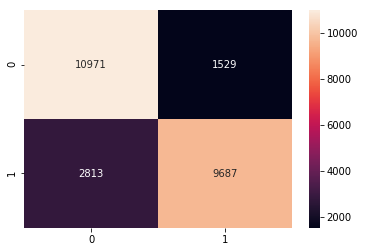

In [23]:
clf = BernoulliNB(alpha=0.7)
clf.fit(train_features,train_y)

y_pred_test = clf.predict(test_features)

test_acc = accuracy_score(test_y, clf.predict(test_features), normalize=True)*float(100)
print('Test_accuracy',(test_acc))

train_acc = accuracy_score(train_y,clf.predict(train_features),normalize=True)*float(100)
print('Train_accuracy',(train_acc))

sns.heatmap(confusion_matrix(test_y,y_pred_test),annot=True,fmt='d')

precision, recall, fscore, support= score(test_y,y_pred_test)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred_test==test_y).sum()/len(y_pred_test),fscore))

Alpha = 5

Test_accuracy 82.648
Train_accuracy 85.96000000000001
precision:[0.79288072 0.86878728], reccall:[0.88384 0.76912], accuracy:0.82648, fscore[0.83589317 0.81592124]


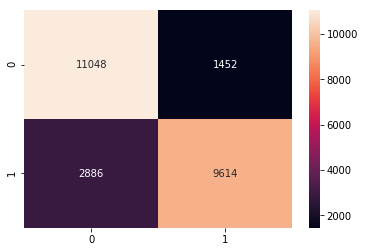

In [24]:
clf = BernoulliNB(alpha=5)
clf.fit(train_features,train_y)

y_pred_test = clf.predict(test_features)

test_acc = accuracy_score(test_y, clf.predict(test_features), normalize=True)*float(100)
print('Test_accuracy',(test_acc))

train_acc = accuracy_score(train_y,clf.predict(train_features),normalize=True)*float(100)
print('Train_accuracy',(train_acc))

sns.heatmap(confusion_matrix(test_y,y_pred_test),annot=True,fmt='d')

precision, recall, fscore, support= score(test_y,y_pred_test)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred_test==test_y).sum()/len(y_pred_test),fscore))

MULTINOMIAL NAIVE BAYES+ TF-IDF

Alpha = 0

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Test_accuracy 82.452
Train_accuracy 88.492
precision:[0.80589699 0.84555754], reccall:[0.85496 0.79408], accuracy:0.82452, fscore[0.82970382 0.81901069]


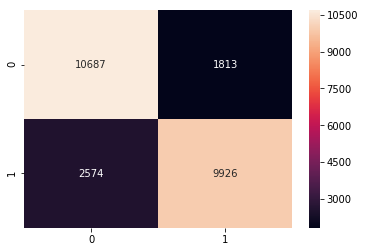

In [25]:
clf = MultinomialNB(alpha=0)
clf.fit(train_features,train_y)

y_pred_test = clf.predict(test_features)

test_acc = accuracy_score(test_y, clf.predict(test_features), normalize=True)*float(100)
print('Test_accuracy',(test_acc))

train_acc = accuracy_score(train_y,clf.predict(train_features),normalize=True)*float(100)
print('Train_accuracy',(train_acc))

sns.heatmap(confusion_matrix(test_y,y_pred_test),annot=True,fmt='d')

precision, recall, fscore, support= score(test_y,y_pred_test)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred_test==test_y).sum()/len(y_pred_test),fscore))

Alpha = 0.7 

Test_accuracy 83.13199999999999
Train_accuracy 88.26
precision:[0.80959856 0.85631937], reccall:[0.8664  0.79624], accuracy:0.83132, fscore[0.83703675 0.82518758]


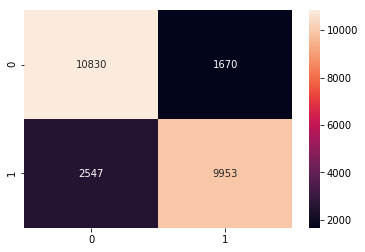

In [26]:
nb_clf = MultinomialNB(alpha=0.7)
nb_clf.fit(train_features,train_y)

y_pred_test = nb_clf.predict(test_features)

test_acc = accuracy_score(test_y, nb_clf.predict(test_features), normalize=True)*float(100)
print('Test_accuracy',(test_acc))
train_acc = accuracy_score(train_y,nb_clf.predict(train_features),normalize=True)*float(100)
print('Train_accuracy',(train_acc))

precision, recall, fscore, support= score(test_y,y_pred_test)
print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred_test==test_y).sum()/len(y_pred_test),fscore))

sns.heatmap(confusion_matrix(test_y,y_pred_test),annot=True,fmt='d')

Alpha =5

Test_accuracy 83.812
Train_accuracy 87.508
precision:[0.80718075 0.87598968], reccall:[0.88848 0.78776], accuracy:0.83812, fscore[0.84588141 0.8295354 ]


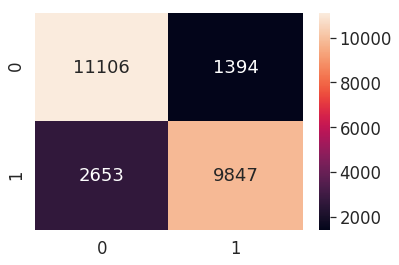

In [42]:
clf = MultinomialNB(alpha=5)
clf.fit(train_features,train_y)

y_pred_test = clf.predict(test_features)

test_acc = accuracy_score(test_y, clf.predict(test_features), normalize=True)*float(100)
print('Test_accuracy',(test_acc))

train_acc = accuracy_score(train_y,clf.predict(train_features),normalize=True)*float(100)
print('Train_accuracy',(train_acc))

sns.heatmap(confusion_matrix(test_y,y_pred_test),annot=True,fmt='d')

precision, recall, fscore, support= score(test_y,y_pred_test)

print("precision:{}, reccall:{}, accuracy:{}, fscore{}".format(precision,recall,(y_pred_test==test_y).sum()/len(y_pred_test),fscore))

Вывод: MULTINOMIAL NAIVE BAYES+ TF-IDF(Alpha =5) наш победитель

### 5. Модель 2: SVM(метод опорных векторов) классификатор

**TF-IDF + SVM: линейный**

In [30]:
train_features = tf_vec.transform(train_x)
test_features = tf_vec.transform(test_x)

svm = SVC(kernel = 'linear',random_state=0, C = 1.0, verbose=True)
svm.fit(train_features,train_y)

pred = svm.predict(test_features)

print(metrics.classification_report(y_true=test_y, y_pred=pred))

[LibSVM]              precision    recall  f1-score   support

         neg       0.87      0.88      0.88     12500
         pos       0.88      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.88      0.87      0.87     25000
weighted avg       0.88      0.87      0.87     25000



**TF-IDF + SVM: 'RBF' ядро**

In [31]:
train_features = tf_vec.fit_transform(train_x)
test_features = tf_vec.transform(test_x)

svm = SVC(kernel = 'rbf',random_state=0, C = 1.0, verbose=True)
svm.fit(train_features,train_y)


pred = svm.predict(test_features)

print(metrics.classification_report(y_true=test_y, y_pred=pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]              precision    recall  f1-score   support

         neg       0.95      0.36      0.53     12500
         pos       0.61      0.98      0.75     12500

    accuracy                           0.67     25000
   macro avg       0.78      0.67      0.64     25000
weighted avg       0.78      0.67      0.64     25000



**TF-IDF + SVM: полином 3 степени**

In [32]:
train_features = tf_vec.fit_transform(train_x)
test_features = tf_vec.transform(test_x)

svm = SVC(kernel = 'poly',degree = 3,random_state=0, C = 1.0, verbose=True)
svm.fit(train_features,train_y)


pred = svm.predict(test_features)

print(metrics.classification_report(y_true=test_y, y_pred=pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]              precision    recall  f1-score   support

         neg       0.98      0.06      0.11     12500
         pos       0.51      1.00      0.68     12500

    accuracy                           0.53     25000
   macro avg       0.75      0.53      0.40     25000
weighted avg       0.75      0.53      0.40     25000



**TF-IDF + SVM: сигмоида**

In [33]:
train_features = tf_vec.fit_transform(train_x)
test_features = tf_vec.transform(test_x)

svm = SVC(kernel = 'sigmoid',random_state=0, C = 1.0, verbose=True)
svm.fit(train_features,train_y)


pred = svm.predict(test_features)

print(metrics.classification_report(y_true=test_y, y_pred=pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]              precision    recall  f1-score   support

         neg       0.95      0.36      0.53     12500
         pos       0.61      0.98      0.75     12500

    accuracy                           0.67     25000
   macro avg       0.78      0.67      0.64     25000
weighted avg       0.78      0.67      0.64     25000



Линейный svm показал себя лучше своих "братьев по векторам" 
1. линейный:accuracy-87 процентов
2. RBF:accuracy-67 процентов
3. полином:accuracy-53 процента
4. сигмойда:accuracy-67 процентов

### 6. Метрики качества PR-Curve, ROC-AUC curve.

In [35]:
train_features = tf_vec.transform(train_x)
test_features = tf_vec.transform(test_x)

svm = SVC(kernel = 'linear',random_state=0, C = 1.0, verbose=True)
svm.fit(train_features,train_y)

pred = svm.predict(test_features)


y_score = svm.decision_function(test_features)

y_train_bin = [1 if y == 'pos' else 0 for y in train_y]

y_test_bin = [1 if y == 'pos' else 0 for y in test_y]

precision, recall, _ = metrics.precision_recall_curve(y_test_bin, y_score)

[LibSVM]

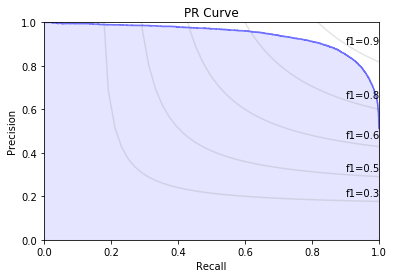

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
import numpy as np


plt.step(recall, precision, color='b', alpha=0.5, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.1, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')


f_scores = np.linspace(0.3, 0.9, num=5)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()
plt.savefig("PRCurve_SVM", dpi=300)

In [0]:
from sklearn.metrics import roc_curve, auc
svm = SVC(kernel = 'rbf',random_state=0, C = 1.0, verbose=True)
y_score = svm.fit(train_features, train_y).decision_function(test_features)

In [96]:
y_test_bin = [1 if y == 'pos' else 0 for y in test_y]
fpr, tpr, thresholds = roc_curve(y_test_bin, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.8945499456


Хороший AUC

AUC: 0.8945499456


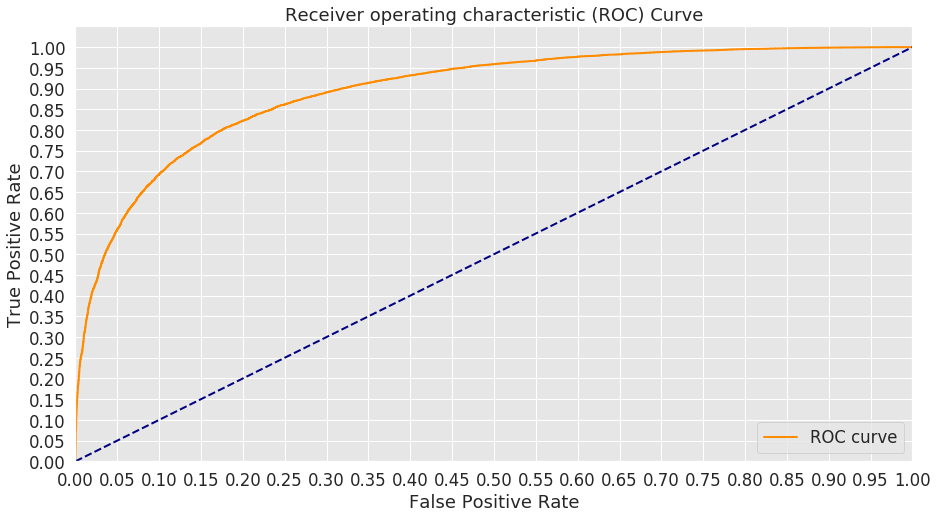

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(15,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

SVM как классификатор показал себя хорош и обе метрики PR и ROC-AUC потвердили это.